L'objectif de ce notebook est de réaliser une transformée de fourier glissante sur un audio pour en extraire la voix seulement en utilisant le gpu pour accelerer l'opération.
En premier lieu, le plus pertinent me paraitrait être d'en developper une version cpu récursive pour povoir la convertir inteligement ensuite pour le gpu.

In [31]:
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import istft

In [32]:
fs, data = wavfile.read("audiocut.wav")
if len(data.shape) > 1: #passer en mono 
    data = data[:, 0]

In [33]:
def fft_recursive(x):
    N = len(x)
    if N <= 1:
        return x

    even = fft_recursive(x[0::2])
    odd = fft_recursive(x[1::2])

    T = [np.exp(-2j * np.pi * k / N) * odd[k] for k in range(N // 2)]

    return [even[k] + T[k] for k in range(N // 2)] + [even[k] - T[k] for k in range(N // 2)]

In [34]:
def fft_glissante_perso(x, fs, nperseg=1024, noverlap=None):
    if noverlap is None:
        noverlap = nperseg // 2

    step = nperseg - noverlap
    windows = []
    times = []

    for start in range(0, len(x) - nperseg + 1, step):
        segment = x[start:start + nperseg]
        segment = segment * np.hanning(nperseg)
        result = fft_recursive(segment)
        windows.append(result)
        times.append(start / fs)

    spectrogram = np.array(windows).T  
    frequencies = np.fft.fftfreq(nperseg, d=1/fs)  
    frequencies = frequencies[frequencies >= 0]  # vire les negatives
    spectrogram = spectrogram[:len(frequencies), :] 
    return frequencies, times, spectrogram

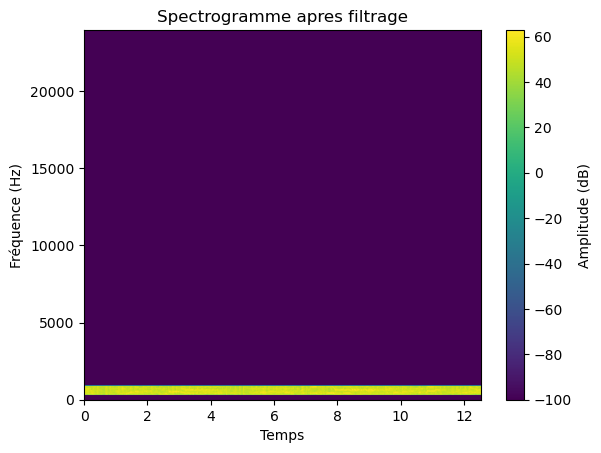

finito pipo


In [35]:
freqs, times, spec = fft_glissante_perso(data, fs, nperseg=1024)


#print(f"tailles freq: {len(freqs)}, shape du spec: {spec.shape}")
#print("freq en gros :", freqs[:10])

spec_filtered = spec.copy()
mask = (freqs >= 300) & (freqs <= 900)
spec_filtered[~mask, :] = 0

# on affiche le spec pour voir si c'est sensé 
plt.imshow(10 * np.log10(np.abs(spec_filtered) + 1e-10), aspect='auto', origin='lower',
           extent=[times[0], times[-1], freqs[0], freqs[-1]]) 
plt.xlabel("Temps")
plt.ylabel("Fréquence (Hz)")
plt.title("Spectrogramme apres filtrage")
plt.colorbar(label="Amplitude (dB)")
plt.show()

#print("min max apres filtre :", np.min(spec_filtered), np.max(spec_filtered))

# reconstruction du signal
_, voice_only = istft(spec_filtered, fs)
voice_only = voice_only / np.max(np.abs(voice_only))  # Éviter le clipping

wavfile.write("voix_extraite.wav", fs, (voice_only * 32767).astype(np.int16))

print("finito pipo")